# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

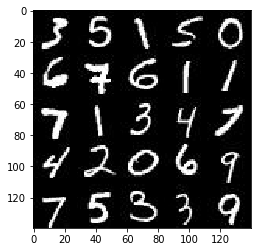

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

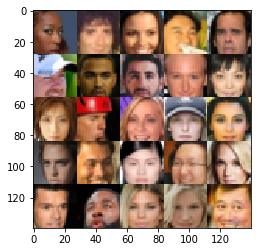

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [22]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
  
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28 28 3
        x1 = tf.layers.conv2d(images, 64, 3, 2, 'same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn1 = tf.layers.batch_normalization(x1, training=True)
        leaky1 = tf.maximum(bn1, bn1 * alpha)
        dropout1 = tf.layers.dropout(leaky1, name='dropout_1', training=True)
        # 14 14 64
        x2 = tf.layers.conv2d(dropout1, 128, 3, 2, 'same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        leaky2 = tf.maximum(bn2, bn2 * alpha)
        dropout2 = tf.layers.dropout(leaky2, name='dropout2', training=True)
        # 7 7 128
        
        flat = tf.reshape(dropout2, (-1, 7 * 7 * 128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [23]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not(is_train)):
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        
        x1 = tf.layers.batch_normalization(x1, training=is_train) 
        x1 = tf.maximum(x1, x1*alpha)
        x1 = tf.layers.dropout(x1, training=is_train)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 3, 2, 'same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 14 14 256
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2, x2*alpha)
        x2 = tf.layers.dropout(x2, training=is_train)
        x3 = tf.layers.conv2d_transpose(x2, out_channel_dim, 3, 2, 'same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28 28 out_channel_dim
        out = tf.tanh(x3)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    input_fake = generator(input_z, out_channel_dim, is_train=True) # What is the training parameter should be?
    real_out, real_logits = discriminator(input_real, reuse=False)
    fake_out, fake_logits = discriminator(input_fake, reuse=True) # This line has some bugs of scope.
    fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.zeros_like(fake_logits)))
    real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, labels=tf.ones_like(real_logits)*(1-smooth)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.ones_like(fake_logits)))
    return fake_loss+real_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

### Here we can try feature maching.

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    variables = tf.trainable_variables()
    g_var = [var for var in variables if var.name.startswith('generator')]
    d_var = [var for var in variables if var.name.startswith('discriminator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        g_loss_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_var)
        d_loss_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_var)
    return d_loss_opt, g_loss_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
%pdb

Automatic pdb calling has been turned OFF


In [34]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    step = 0
    sample_z = np.random.uniform(-1, 1, (batch_size, z_dim))
    # input
    _, width, height, channels = data_shape
    input_real, input_z, lr  = model_inputs(width, height, channels, z_dim)
    # model loss
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    # model optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images*2
                # TODO: Train Model
                step += 1
                # sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers Run G twice to give it a chance to beat D.
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real:batch_images, lr:learning_rate})
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real:batch_images, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real:batch_images, lr:learning_rate})
                
                
                # Show the loss every 100 steps.
                if step % 25 == 0:
                    print('Step:', step,
                          'D loss:', d_loss.eval({input_real: batch_images, input_z: batch_z, lr:learning_rate}),
                          'G loss:', g_loss.eval({input_z: batch_z, lr:learning_rate}))
                if step % 400 == 0:
                    show_generator_output(sess, 9, input_z, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step: 25 D loss: 1.34286 G loss: 1.15067
Step: 50 D loss: 1.57455 G loss: 0.951245
Step: 75 D loss: 1.37549 G loss: 1.0197
Step: 100 D loss: 1.41707 G loss: 1.41474
Step: 125 D loss: 1.60973 G loss: 1.86789
Step: 150 D loss: 1.57498 G loss: 0.854027
Step: 175 D loss: 1.51953 G loss: 1.86923
Step: 200 D loss: 1.29202 G loss: 0.903871
Step: 225 D loss: 1.1574 G loss: 1.07745
Step: 250 D loss: 1.28439 G loss: 1.68703
Step: 275 D loss: 1.21743 G loss: 1.402
Step: 300 D loss: 1.17741 G loss: 1.55587
Step: 325 D loss: 1.32888 G loss: 1.1278
Step: 350 D loss: 1.22865 G loss: 1.14593
Step: 375 D loss: 1.1766 G loss: 1.05201
Step: 400 D loss: 1.18493 G loss: 1.12612


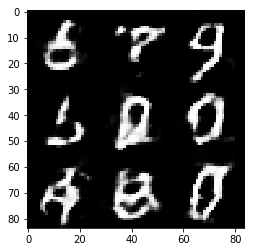

Step: 425 D loss: 1.54571 G loss: 0.631654
Step: 450 D loss: 1.42435 G loss: 2.01446
Step: 475 D loss: 1.18525 G loss: 0.953863
Step: 500 D loss: 1.08388 G loss: 1.13656
Step: 525 D loss: 1.07821 G loss: 1.09447
Step: 550 D loss: 1.05483 G loss: 0.958974
Step: 575 D loss: 1.11652 G loss: 1.65807
Step: 600 D loss: 1.07133 G loss: 1.13604
Step: 625 D loss: 1.07367 G loss: 1.80267
Step: 650 D loss: 1.03422 G loss: 1.38704
Step: 675 D loss: 1.21313 G loss: 1.88873
Step: 700 D loss: 1.07103 G loss: 1.6059
Step: 725 D loss: 1.19744 G loss: 1.40754
Step: 750 D loss: 1.19797 G loss: 1.28295
Step: 775 D loss: 0.886746 G loss: 1.37894
Step: 800 D loss: 1.06124 G loss: 1.92497


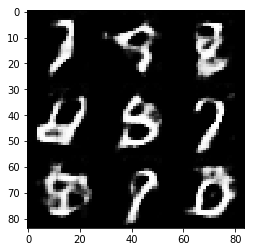

Step: 825 D loss: 1.16025 G loss: 1.3488
Step: 850 D loss: 0.945301 G loss: 1.35176
Step: 875 D loss: 1.05798 G loss: 2.54394
Step: 900 D loss: 1.2005 G loss: 1.19609
Step: 925 D loss: 1.49937 G loss: 3.08183
Step: 950 D loss: 1.05355 G loss: 1.31161
Step: 975 D loss: 0.976258 G loss: 1.64528
Step: 1000 D loss: 1.007 G loss: 1.34358
Step: 1025 D loss: 0.88267 G loss: 1.48352
Step: 1050 D loss: 1.1268 G loss: 2.05747
Step: 1075 D loss: 0.935236 G loss: 2.23031
Step: 1100 D loss: 0.884109 G loss: 1.92552
Step: 1125 D loss: 0.927777 G loss: 1.97657
Step: 1150 D loss: 0.949884 G loss: 2.334
Step: 1175 D loss: 0.890607 G loss: 2.11094
Step: 1200 D loss: 1.00452 G loss: 2.25044


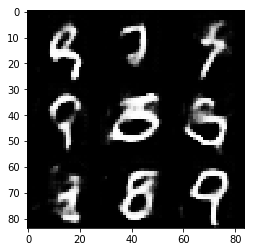

Step: 1225 D loss: 0.848365 G loss: 2.23404
Step: 1250 D loss: 0.901895 G loss: 1.42471
Step: 1275 D loss: 0.829378 G loss: 2.36057
Step: 1300 D loss: 0.83654 G loss: 2.02568
Step: 1325 D loss: 0.848691 G loss: 1.62378
Step: 1350 D loss: 1.09015 G loss: 0.851057
Step: 1375 D loss: 0.985553 G loss: 1.61647
Step: 1400 D loss: 1.01845 G loss: 2.29312
Step: 1425 D loss: 0.978699 G loss: 1.45489
Step: 1450 D loss: 0.801044 G loss: 2.5117
Step: 1475 D loss: 0.695696 G loss: 1.56037
Step: 1500 D loss: 0.751748 G loss: 1.56938
Step: 1525 D loss: 0.959688 G loss: 2.66206
Step: 1550 D loss: 0.864113 G loss: 1.29703
Step: 1575 D loss: 0.761321 G loss: 2.31015
Step: 1600 D loss: 0.848465 G loss: 1.14454


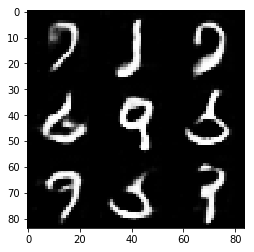

Step: 1625 D loss: 0.846719 G loss: 1.83753
Step: 1650 D loss: 0.894164 G loss: 1.34712
Step: 1675 D loss: 1.02889 G loss: 1.26351
Step: 1700 D loss: 1.1003 G loss: 3.06039
Step: 1725 D loss: 0.778175 G loss: 1.83992
Step: 1750 D loss: 0.692114 G loss: 1.8515
Step: 1775 D loss: 1.12173 G loss: 3.18082
Step: 1800 D loss: 0.711616 G loss: 2.34027
Step: 1825 D loss: 0.871064 G loss: 1.92751
Step: 1850 D loss: 0.794876 G loss: 2.48299


In [35]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step: 25 D loss: 0.92755 G loss: 1.90985
Step: 50 D loss: 1.06152 G loss: 1.98114
Step: 75 D loss: 0.989166 G loss: 2.60737
Step: 100 D loss: 0.861389 G loss: 2.67531
Step: 125 D loss: 0.59413 G loss: 2.80156
Step: 150 D loss: 0.582519 G loss: 2.97558
Step: 175 D loss: 0.67253 G loss: 3.62809
Step: 200 D loss: 0.701882 G loss: 2.10966
Step: 225 D loss: 0.744884 G loss: 2.19533
Step: 250 D loss: 1.00776 G loss: 1.86684
Step: 275 D loss: 0.895753 G loss: 2.07117
Step: 300 D loss: 0.914794 G loss: 1.68807
Step: 325 D loss: 0.935616 G loss: 1.8701
Step: 350 D loss: 1.2786 G loss: 1.41789
Step: 375 D loss: 0.843586 G loss: 2.00924
Step: 400 D loss: 0.977909 G loss: 1.16707


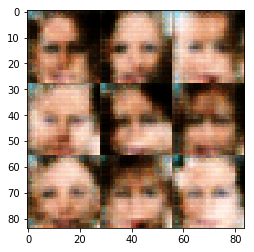

Step: 425 D loss: 0.896274 G loss: 2.99012
Step: 450 D loss: 0.848048 G loss: 1.24966
Step: 475 D loss: 0.860027 G loss: 2.08667
Step: 500 D loss: 0.899472 G loss: 2.11822
Step: 525 D loss: 0.767722 G loss: 1.56621
Step: 550 D loss: 0.977583 G loss: 1.64608
Step: 575 D loss: 1.26245 G loss: 1.62193
Step: 600 D loss: 1.10686 G loss: 2.09535
Step: 625 D loss: 0.973911 G loss: 1.80875
Step: 650 D loss: 1.10355 G loss: 1.40645
Step: 675 D loss: 1.34691 G loss: 2.06612
Step: 700 D loss: 0.921251 G loss: 1.84714
Step: 725 D loss: 1.09297 G loss: 1.23842
Step: 750 D loss: 1.33303 G loss: 1.79571
Step: 775 D loss: 1.08293 G loss: 1.37783
Step: 800 D loss: 1.13514 G loss: 1.61673


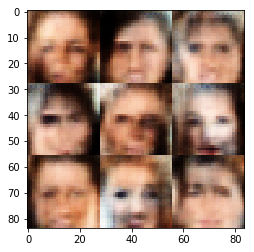

Step: 825 D loss: 1.11325 G loss: 1.60641
Step: 850 D loss: 1.22544 G loss: 1.4566
Step: 875 D loss: 1.37251 G loss: 1.37699
Step: 900 D loss: 1.19789 G loss: 1.62908
Step: 925 D loss: 1.51244 G loss: 1.15629
Step: 950 D loss: 1.35723 G loss: 0.900232
Step: 975 D loss: 1.09592 G loss: 1.22135
Step: 1000 D loss: 1.10063 G loss: 1.38888
Step: 1025 D loss: 1.17287 G loss: 1.41455
Step: 1050 D loss: 0.959777 G loss: 1.08363
Step: 1075 D loss: 1.25256 G loss: 1.03299
Step: 1100 D loss: 0.877524 G loss: 1.50303
Step: 1125 D loss: 1.1222 G loss: 1.52469
Step: 1150 D loss: 1.05956 G loss: 1.41658
Step: 1175 D loss: 1.13125 G loss: 1.17865
Step: 1200 D loss: 1.17697 G loss: 1.15399


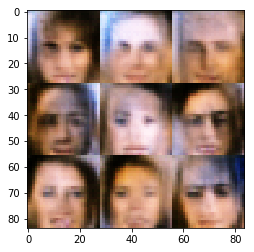

Step: 1225 D loss: 1.23471 G loss: 1.08233
Step: 1250 D loss: 1.1575 G loss: 1.52421
Step: 1275 D loss: 0.954405 G loss: 1.46016
Step: 1300 D loss: 1.1192 G loss: 1.18005
Step: 1325 D loss: 1.24809 G loss: 1.08228
Step: 1350 D loss: 0.88111 G loss: 1.65046
Step: 1375 D loss: 1.07959 G loss: 1.38956
Step: 1400 D loss: 1.26502 G loss: 1.45352
Step: 1425 D loss: 1.06758 G loss: 1.65205
Step: 1450 D loss: 0.809653 G loss: 1.31488
Step: 1475 D loss: 0.975811 G loss: 1.60288
Step: 1500 D loss: 1.36542 G loss: 0.901004
Step: 1525 D loss: 1.2676 G loss: 1.11226
Step: 1550 D loss: 1.1836 G loss: 0.884078
Step: 1575 D loss: 1.05244 G loss: 1.28259
Step: 1600 D loss: 1.10995 G loss: 1.11314


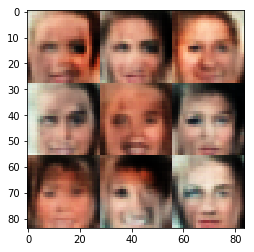

Step: 1625 D loss: 1.21302 G loss: 1.54657
Step: 1650 D loss: 0.922673 G loss: 1.39855
Step: 1675 D loss: 1.39408 G loss: 1.27274
Step: 1700 D loss: 1.25242 G loss: 1.38819
Step: 1725 D loss: 1.05257 G loss: 1.2153
Step: 1750 D loss: 1.15952 G loss: 1.38393
Step: 1775 D loss: 1.20258 G loss: 1.30591
Step: 1800 D loss: 1.11667 G loss: 0.858493
Step: 1825 D loss: 1.22584 G loss: 1.35667


In [36]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.